In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

In [2]:
from datetime import datetime as dt
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils.utils import plot_images
from models.ibp_model import *

1.7.0
True


In [3]:
def pgd(model, X, y, loss_fn, epsilon=8/255, alpha=2/255, num_iter=10):
    delta = torch.zeros_like(X, requires_grad=True)
    for _ in range(num_iter):
        l, u = model(torch.cat([X + delta, X + delta], dim=1))
        out = (l+u)/2
        loss = loss_fn(out, y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.grad.zero_()
    return delta.detach()

In [4]:
from datetime import datetime as dt

def clean_acc(model, loader):
    clean_correct = 0.
    model.eval()
    with torch.no_grad():
        for k, (X, y) in enumerate(loader, 1):
            start = dt.now().replace(microsecond=0)
            X, y = X.to(device), y.to(device)  
            clean_correct += (model(torch.cat([X,X], dim=1))[0].argmax(dim=1) == y).sum().item()
            end = dt.now().replace(microsecond=0)
            print(f"iter: {k}/{len(loader)} time: {end-start}", end="\r")
        print(" " * 50, end="\r")
        acc = round(clean_correct / len(loader.dataset), 4)
        print(f"clean accuracy: {acc}")
    return acc

def adv_acc(model, loader, loss_fn, attack, attack_params):
    model.eval()
    adv_correct = [0] * len(attack_params)
    for i, (name, params) in enumerate(attack_params):
        for k, (X, y) in enumerate(loader, 1):
            start = dt.now().replace(microsecond=0)
            X, y = X.to(device), y.to(device)
            noise = attack(model, X, y, loss_fn, **params)
            l, u = model(torch.cat([X+noise, X+noise], dim=1))
            adv_correct[i] += (l.argmax(dim=1) == y).sum().item()
            end = dt.now().replace(microsecond=0)
            print(f"iter: {k}/{len(loader)} time: {end-start}", end="\r")
        print(" " * 50, end="\r")
        print(f"name: {name} accuracy: {(adv_correct[i] / len(loader.dataset)):.4f}")
    return [round(a/len(loader.dataset), 4) for a in adv_correct]


def print_table(models, attacks, clean, adv):
    d = {'model': models, 'clean image': clean}
    for i, (name, p) in enumerate(attacks):
        d[name] = [adv[j][i] for j, _ in enumerate(adv)]

    return pd.DataFrame(data=d)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [6]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

ds = MNIST('../data', train=False, target_transform=None, download=True, transform=test_transform)
test_loader = DataLoader(ds, 2000, shuffle=True)
img_loader = DataLoader(ds, 20, shuffle=True)

In [7]:
def create_attack(eps, alpha, num_iter):
    d = {
        "epsilon": eps,
        "alpha": alpha,
        "num_iter": num_iter
    }
    return f"e={eps:.1f},a={alpha:.1f},i={num_iter}", d
    

attack1 = create_attack(eps=0.1, alpha=0.1, num_iter=30)
attack2 = create_attack(eps=0.2, alpha=0.1, num_iter=30)
attack3 = create_attack(eps=0.3, alpha=0.1, num_iter=30)
attack4 = create_attack(eps=0.4, alpha=0.1, num_iter=30)
attack5 = create_attack(eps=0.5, alpha=0.1, num_iter=30)


params = [attack1, attack2, attack3, attack4, attack5]

In [8]:
clean, adv = [], []

In [9]:
model = MnistIBPModel().to(device)
model.load_state_dict(torch.load("../saved/ibp_model.pt", map_location=device))

acc = clean_acc(model, test_loader)
acc_adv = adv_acc(model, test_loader, nn.CrossEntropyLoss(), pgd, params)

clean.append(acc)
adv.append(acc_adv)

clean accuracy: 0.9526                            
name: e=0.1,a=0.1,i=30 accuracy: 0.9370           
name: e=0.2,a=0.1,i=30 accuracy: 0.9160           
name: e=0.3,a=0.1,i=30 accuracy: 0.8908           
name: e=0.4,a=0.1,i=30 accuracy: 0.0699           
name: e=0.5,a=0.1,i=30 accuracy: 0.0122           


In [10]:
models_names = ["IBP model"]
ibp = print_table(models_names, params, clean, adv)
ibp

,model,clean image,"e=0.1,a=0.1,i=30","e=0.2,a=0.1,i=30","e=0.3,a=0.1,i=30","e=0.4,a=0.1,i=30","e=0.5,a=0.1,i=30"
0,IBP model,0.9526,0.937,0.916,0.8908,0.0699,0.0122


In [11]:
def plot_images(X, y, yp, M, N):
    f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N, M*1.5))
    X, y, yp = X.cpu(), y.cpu(), yp[0].cpu()
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(X[i*N+j].detach().permute(1,2,0))

            pred_label = yp[i*N+j].argmax(dim=0)
            title = ax[i][j].set_title(pred_label.item())
            plt.setp(title, color=('g' if pred_label == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

In [12]:
for X, y in img_loader:
    X, y = X.to(device), y.to(device)
    break

## Clean Images

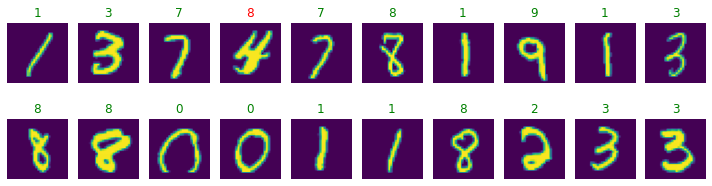

In [13]:
plot_images(X, y, model(torch.cat([X, X], dim=1)), 2, 10)

## PGD attack with eps=0.1

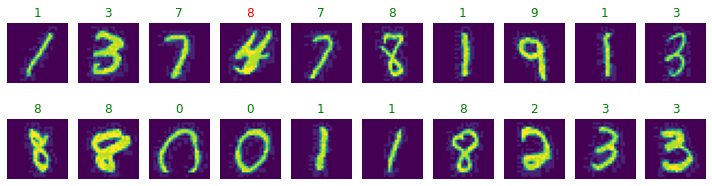

In [14]:
noise = pgd(model, X, y, nn.CrossEntropyLoss(), epsilon=0.1, alpha=0.1, num_iter=30)
adv_ex = X+noise
plot_images(adv_ex, y, model(torch.cat([adv_ex, adv_ex], dim=1)), 2, 10)

## PGD attack with eps=0.2

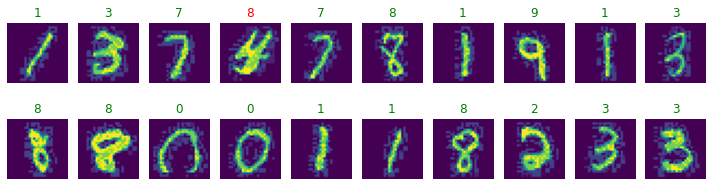

In [15]:
noise = pgd(model, X, y, nn.CrossEntropyLoss(), epsilon=0.2, alpha=0.1, num_iter=30)
adv_ex = X+noise
plot_images(adv_ex, y, model(torch.cat([adv_ex, adv_ex], dim=1)), 2, 10)

## PGD attack with eps=0.3

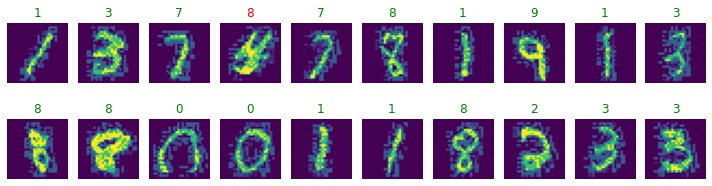

In [16]:
noise = pgd(model, X, y, nn.CrossEntropyLoss(), epsilon=0.3, alpha=0.1, num_iter=30)
adv_ex = X+noise
plot_images(adv_ex, y, model(torch.cat([adv_ex, adv_ex], dim=1)), 2, 10)

## PGD attack with eps=0.4

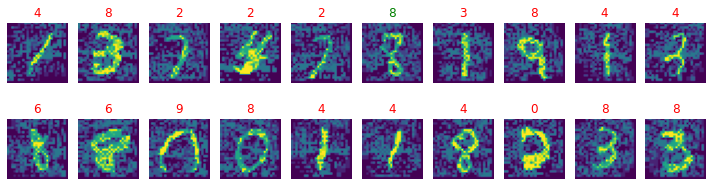

In [17]:
noise = pgd(model, X, y, nn.CrossEntropyLoss(), epsilon=0.4, alpha=0.1, num_iter=30)
adv_ex = X+noise
plot_images(adv_ex, y, model(torch.cat([adv_ex, adv_ex], dim=1)), 2, 10)

## PGD attack with eps=0.5

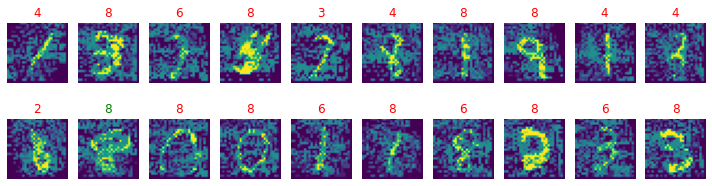

In [18]:
noise = pgd(model, X, y, nn.CrossEntropyLoss(), epsilon=0.5, alpha=0.1, num_iter=30)
adv_ex = X+noise
plot_images(adv_ex, y, model(torch.cat([adv_ex, adv_ex], dim=1)), 2, 10)